# 2018 CDC Natality Data Set

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch

warnings.filterwarnings("ignore")

## Data Cleaning

In [2]:
df = pd.read_csv('../data/NBER/natl2018us.csv')

# Keep only single births and first pregnancy
df = df[df['dplural'] == 1]
df = df[df['ilp_r'] == 888]

# Subset of indicators to consider
df = df[['mager9', 'mbstate_rec', 'mracehisp', 'meduc', 'precare5', 'wic', 'pay_rec']]

# Get rid of unknowns
df = df[df['mbstate_rec'] != 3] # Unknown nativity
df = df[df['mracehisp'] != 8]   # Unknown race
df = df[df['meduc'] != 9]       # Unknown education
df = df[df['precare5'] != 5]    # Unknown prenatal care
df = df[df['wic'] != 'U']       # Unknown WIC
df = df[df['pay_rec'] != 9]     # Unknown payment method

# Change encoding for WIC
df['wic'] = df.apply(lambda row: int(row['wic'] == 'Y'), axis=1)

# Create prenatal care column
df['prenatal'] = df.apply(lambda row: int(row['precare5'] != 4), axis=1)
df.to_csv('../data/NBER/natl2018us_subset.csv', index=False)

## Indicators

In [3]:
# Month prenatal care began (`precare5`)
month_dict = {
    1: '1st-3rd month',
    2: '4th-6th month',
    3: '7th-final month',
    4: 'No prenatal care'
}

# Mother's age (`mager9`)
age_dict = {
    1: 'Under 15 years',
    2: '15-19 years',
    3: '20-24 years',
    4: '25-29 years',
    5: '30-34 years',
    6: '35-39 years',
    7: '40-44 years',
    8: '45-49 years',
    9: '50-54 years'
}

# Mother's nativity (`mbstate_rec`)
nat_dict = {
    1: 'Born in the US',
    2: 'Born outside the US'
}
# Should we make this binary?

# Mother's race/Hispanic origin (`mracehisp`)
race_dict = {
    1: 'White',
    2: 'Black',
    3: 'AIAN',
    4: 'Asian',
    5: 'NHOPI',
    6: 'More than one race',
    7: 'Hispanic'
}

# Mother's education (`meduc`)
educ_dict = {
    1: '8th grade or less',
    2: '9th through 12th with no diploma',
    3: 'High school graduate or GED completed',
    4: 'Some college credit, but not a degree',
    5: 'Associate degree',
    6: "Bachelor's degree",
    7: "Master's degree",
    8: 'Doctorate'
}

# WIC (`wic`)
wic_dict = {
    0: 'No',
    1: 'Yes'
}

# Payment source for delivery (`pay_rec`)  
pay_dict = {
    1: 'Medicaid',
    2: 'Private Insurance',
    3: 'Self Pay',
    4: 'Other'
}

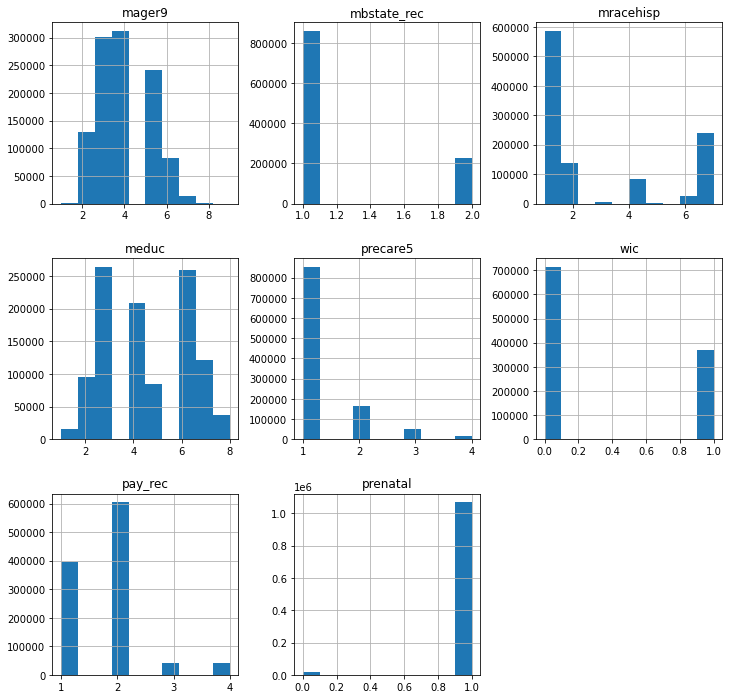

In [4]:
df.hist(figsize=(12, 12));

## When did people start prenatal care?

In [5]:
def plot_month(col, col_name, col_dict):
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    for ii in np.sort(df['precare5'].unique()):
        col_list = []
        per_list = [] 
        for jj in np.sort(df[col].unique()):
            df_sub = df[df[col] == jj]
            col_list.append(col_dict[jj])
            per_list.append(100*len(df_sub[df_sub['precare5'] == ii])/len(df_sub))
        temp = pd.DataFrame({
            col_name: col_list,
            'Care': per_list
        })
        sns.barplot(x=col_name, y='Care', data=temp, ax=ax[ii-1])
        ax[ii-1].set_xticklabels(col_list, rotation=90)
        if ii == 4:
            ax[ii-1].set_ylabel(f"Percent {month_dict[ii]}")
        else:
            ax[ii-1].set_ylabel(f"Percent Started Care in {month_dict[ii]}")

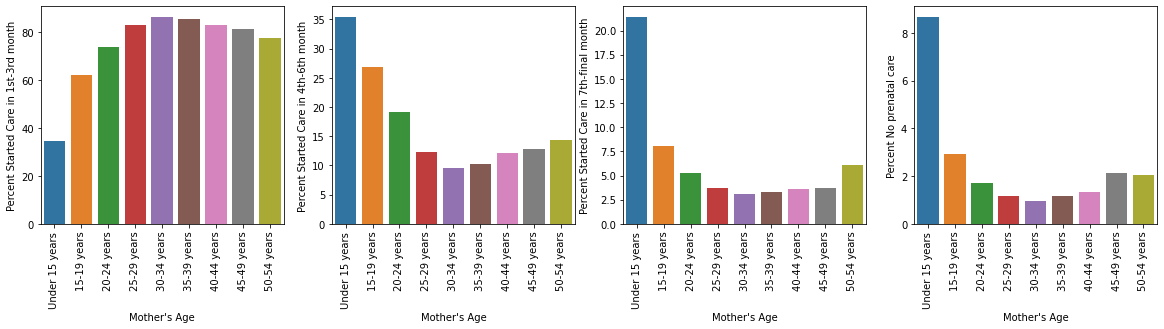

In [6]:
plot_month('mager9', "Mother's Age", age_dict)

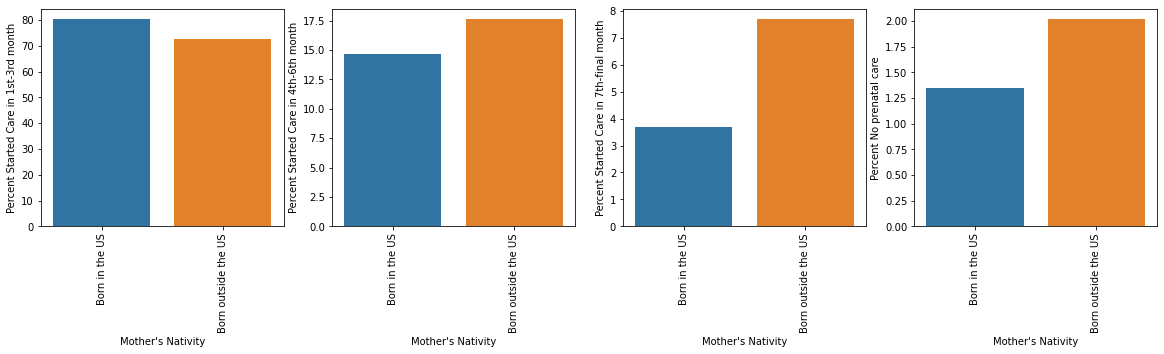

In [7]:
plot_month('mbstate_rec', "Mother's Nativity", nat_dict)

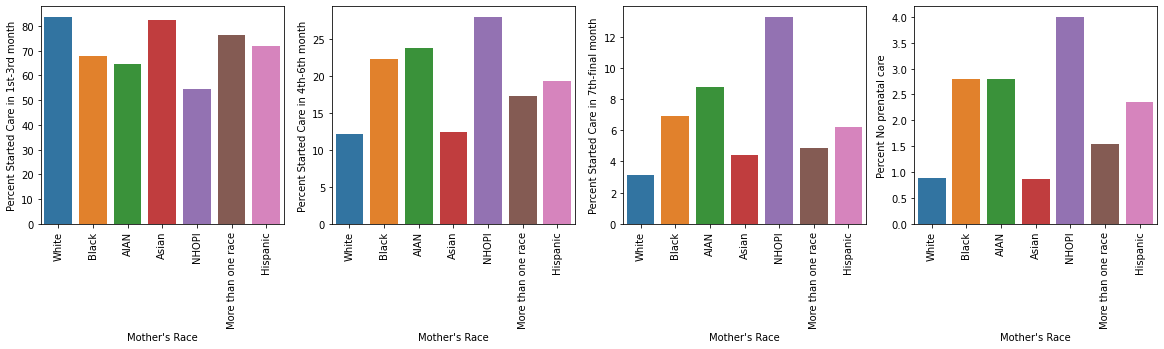

In [8]:
plot_month('mracehisp', "Mother's Race", race_dict)

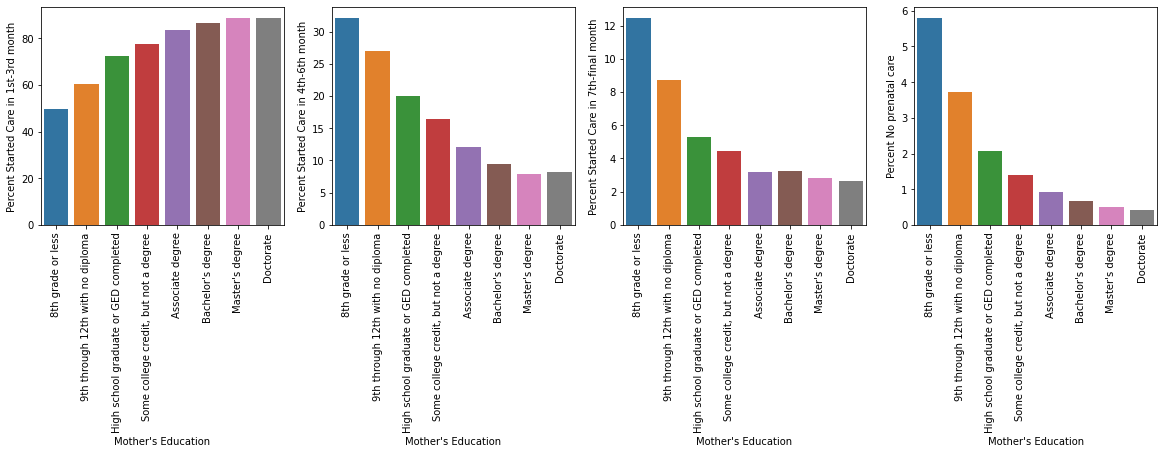

In [9]:
plot_month('meduc', "Mother's Education", educ_dict)

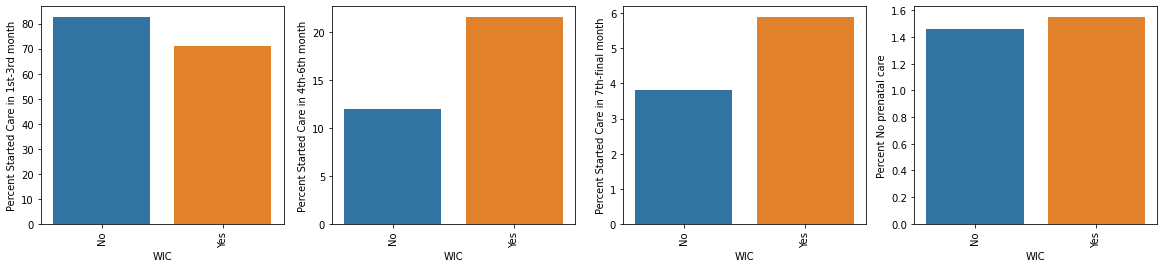

In [10]:
plot_month('wic', 'WIC', wic_dict)

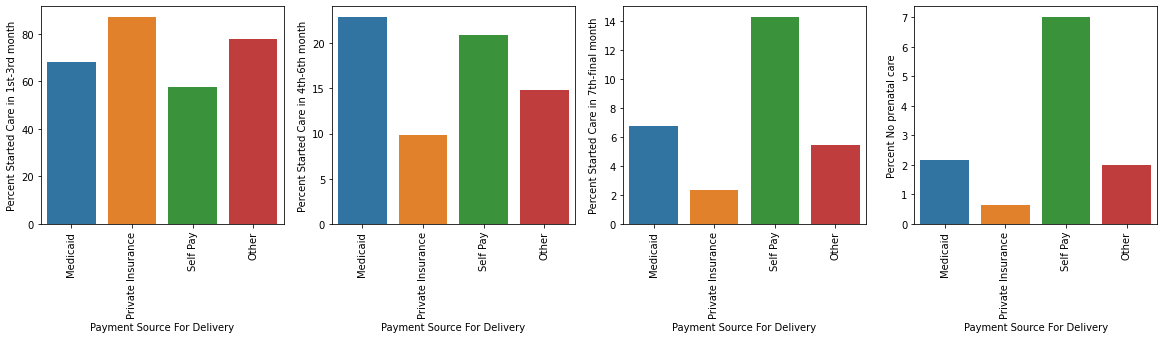

In [11]:
plot_month('pay_rec', 'Payment Source For Delivery', pay_dict)

## Are any indicators correlated?

Disclaimer: 

Indicators either binary, binned, or categorical, so some things below won't make sense. For example, below it looks like mother's birthplace and race are correlated, but the race column is categorical, so the numerical values don't have a meaning.

What does make sense:

Relationship between mother's age, education, and possibly WIC

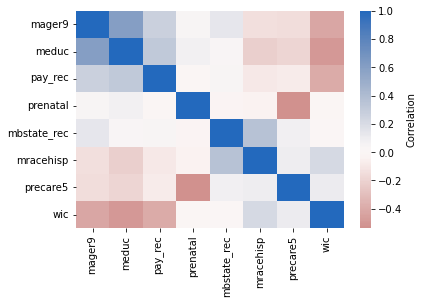

In [12]:
X = df.corr().values
d = sch.distance.pdist(X)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df_cluster = df.reindex(columns, axis=1)
sns.heatmap(df_cluster.corr(), cmap='vlag_r', center=0, cbar_kws={'label': 'Correlation'});

Maybe we can get more information when we split the categorical variables into 0-1 variables.

Some observations:
* Age, education, and private insurance are positively correlated
* WIC negatively correlated with private insurance and positively correlated with Medicaid
* Month prenatal care starts negatively correlated with age, education, private insurance (lower values mean started care sooner)

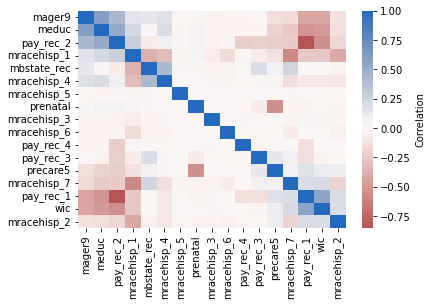

In [13]:
df2 = pd.get_dummies(df, columns=['pay_rec', 'mracehisp'])
X = df2.corr().values
d = sch.distance.pdist(X)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [df2.columns.tolist()[i] for i in list((np.argsort(ind)))]
df_cluster = df2.reindex(columns, axis=1)
sns.heatmap(df_cluster.corr(), cmap='vlag_r', center=0, cbar_kws={'label': 'Correlation'});

## Dimensionality

Seems like a low-rank data set, but not completely straightforward to interpret.

In [14]:
X = df2.values
U, S, Vh = np.linalg.svd(X, full_matrices=False)

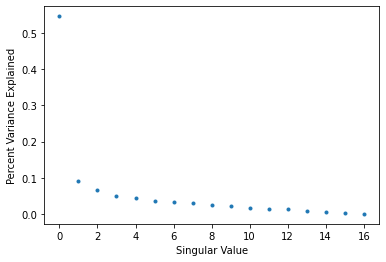

In [15]:
plt.plot(S/sum(S), '.')
plt.xlabel('Singular Value')
plt.ylabel('Percent Variance Explained');

## Can we predict when prenatal care begins by indicators?

In [16]:
# Multi-class classification problem
# Multinomial logistic regression

## Which indicators are the most important?

In [17]:
# L1 regularization path